
<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Artificial Intelligence and Machine Learning</center></font></h1>
<h1><center>Supervised Learning Classification: Personal Loan Campaign</center></h1>
<h4><center>Author: Enrique Martin Sanchez</center></h4>

# Description
## Background and Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan

## Objective

1. To predict whether a liability customer will buy a personal loan or not.
2. Which variables are most significant.
3. Which segment of customers should be targeted more.

## Data Dictionary

* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIP Code: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV

%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')



# Support Functions

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = "{:,.0f}".format(
                p.get_height()
              )  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to treat outliers

def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1                # Inter Quantile Range (75th percentile - 25th percentile)
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    # all the values smaller than lower_whisker will be assigned the value of lower_whisker
    # all the values greater than upper_whisker will be assigned the value of upper_whisker
    # the assignment will be done by using the clip function of NumPy
    df[col] = np.clip(df[col], lower_whisker, upper_whisker)

    return df

In [ ]:
# function to plot an scatterplot and a lineplot at the same time

def scatter_lineplot(data, feature_x, feature_y, figsize=(12, 7)):
  """
  Boxplot and scatter and lineplot combined

  data: dataframe
  feature_x: dataframe column in x axis
  feature_y: dataframe column in y axis
  figsize: size of figure (default (12,7))
  """
  
  f2, (ax_scatter, ax_line) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.5, 0.5)},
        figsize=figsize,
  ) # creating the 2 subplots
  sns.scatterplot(
      data=data, x=feature_x, y=feature_y, ax=ax_scatter, color="orange"
  ).set_title(feature_x + ' vs ' + feature_y)
  sns.lineplot(
      data=data,  x=feature_x, y=feature_y, ax=ax_line, color="blue", ci=None
  ) 
  

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn with threshold

def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cbar=False)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cbar=False)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
#funtion to print a tree with if / else notation

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,6)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,6)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            if tree_.value[node][0][0] > tree_.value[node][0][1]:
              cl = 0
            else:
              cl = 1
            print("{}return {} class {}".format(indent, tree_.value[node], cl))

    recurse(0, 1)

# Understanding the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Science/Courses/AIML University of Texas/Supervised Learning: Classification/Proyecto/Loan_Modelling.csv')
df = data.copy()

In [ ]:
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


**Insights**
- ID seems to be an identifier will see later if its unique of every row

In [ ]:
df.shape

(5000, 14)

**Insights**
The data has 5,000 rows and 14 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


**Insights**
- Data have 13 int columns
- Data have 1 float columns


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,"5,000.00","2,500.50","1,443.52",1.00,"1,250.75","2,500.50","3,750.25","5,000.00"
Age,"5,000.00",45.34,11.46,23.00,35.00,45.00,55.00,67.00
Experience,"5,000.00",20.10,11.47,-3.00,10.00,20.00,30.00,43.00
Income,"5,000.00",73.77,46.03,8.00,39.00,64.00,98.00,224.00
ZIPCode,"5,000.00","93,169.26","1,759.46","90,005.00","91,911.00","93,437.00","94,608.00","96,651.00"
Family,"5,000.00",2.40,1.15,1.00,1.00,2.00,3.00,4.00
CCAvg,"5,000.00",1.94,1.75,0.00,0.70,1.50,2.50,10.00
Education,"5,000.00",1.88,0.84,1.00,1.00,2.00,3.00,3.00
Mortgage,"5,000.00",56.50,101.71,0.00,0.00,0.00,101.00,635.00
Personal_Loan,"5,000.00",0.10,0.29,0.00,0.00,0.00,0.00,1.00


**Insights**
- Age varies from 23 to 67 years, with amean of 45.34
- Experience ranges from -3 to 43, -3 does not seem like an accurate value, we will look into it later
- Income varies from 8 to 224 thousand dollars, seem to be a right skewness
- ZIPCode numerical analysis does not make any sense, we will figure it out later on
- Family size ranges between 1 and 4 it is an encoded categorical variable
- CCAVg, customers spend on credit card per mnth from 0 to 10 thousand dollars, with a mean of 1.94 it seems to be right skewness
- Education is an encoded categorical variable
- Mortgage there are a lot of 0s in the field, we will figure it out later
- Seems that a lot of customers did not accepted the last personal loan offer (at least 75% of them)
- Securities_Account, CD_Account, Online, CreditCard fields are encoded categorical variables

In [ ]:
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

**Insights** 
- There are non missing values in the data

# Exploratory Data Analysis & data preprocessing

## Variable classification

In [ ]:
num_cols = ['Age','Experience','Income','CCAvg','Mortgage']
cat_cols = ['Family','Education','Securities_Account','CD_Account','Online','CreditCard']
#ZipCode will be analyzed separately
#Personal_loan is our target variable

# Univariate analysis

## ID

In [ ]:
df.ID.nunique()

5000

In [ ]:
df.drop('ID', axis=1, inplace=True)
df.sample()

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
499,50,25,42,93108,3,1.70,2,0,0,0,0,1,0


**Insights**
- ID is a unique identifier for every row, so it is useless for the model, so we drop it from the dataframe


## Age

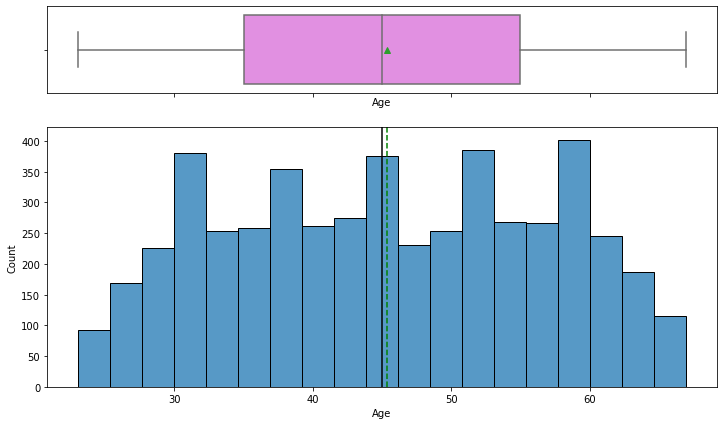

In [ ]:
histogram_boxplot(data=df, feature='Age')

In [ ]:
df.Age.describe()

count   5,000.00
mean       45.34
std        11.46
min        23.00
25%        35.00
50%        45.00
75%        55.00
max        67.00
Name: Age, dtype: float64

**Insights**
- There are not outlayers
- Data does not look skewed
- Min age: 23 years
- Max age: 67 years
- Mean of 45.34 years

## ZIPCode

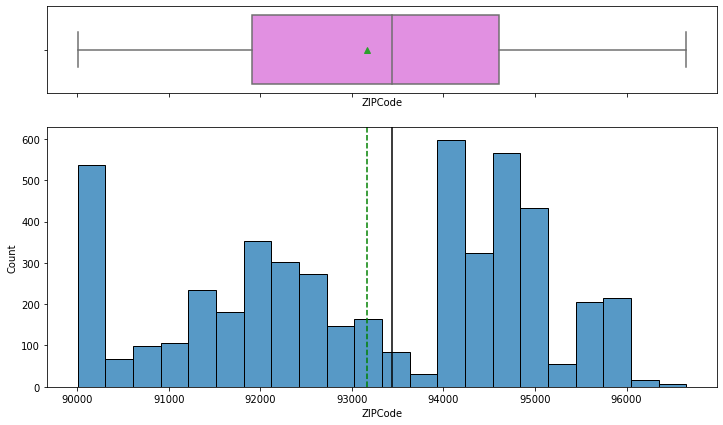

In [ ]:
histogram_boxplot(data=df, feature='ZIPCode')

In [ ]:
print(f'Min zipcode: {df.ZIPCode.min()}\nMax zipcode: {df.ZIPCode.max()}')


Min zipcode: 90005
Max zipcode: 96651


** Insights **
- All the zip codes are from California
- We will treat this column later on

## Experience

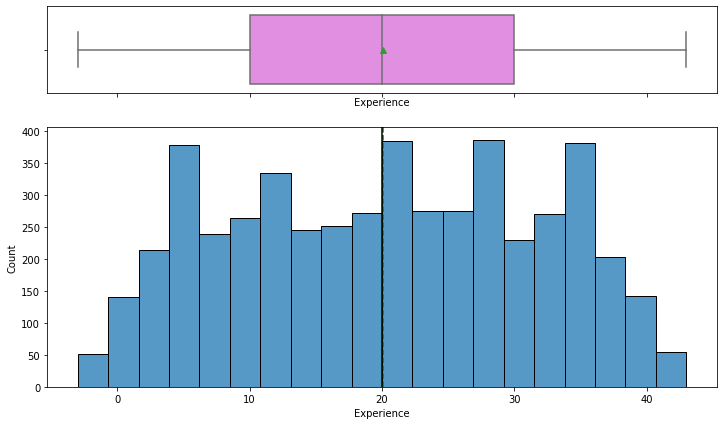

In [ ]:
histogram_boxplot(data=df, feature='Experience')

In [ ]:
df.Experience.describe()

count   5,000.00
mean       20.10
std        11.47
min        -3.00
25%        10.00
50%        20.00
75%        30.00
max        43.00
Name: Experience, dtype: float64

In [ ]:
df[df.Experience < 0].Experience.value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

Negative expeerience years make no sense we will treat them and replace them with zero years

In [ ]:
def treat_exp(val):
  if val < 0:
    return 0
  else:
    return val
df.Experience = df.Experience.apply(treat_exp)

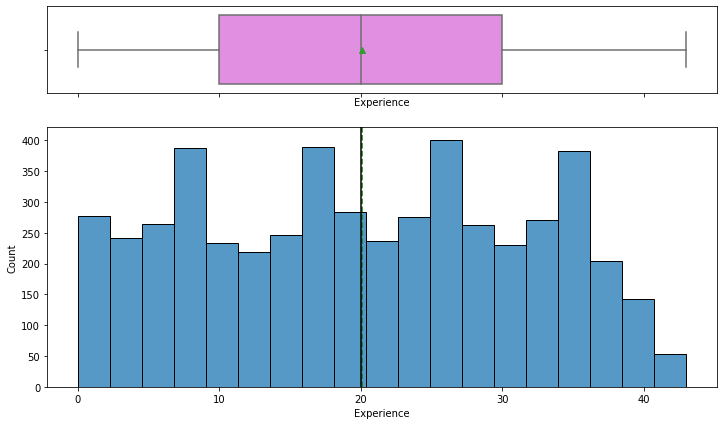

In [ ]:
histogram_boxplot(data=df, feature='Experience')

**Insights**
- Treated negative values and replace them with zero
- No outliers in the result
- Data does not seem skewed

## Income

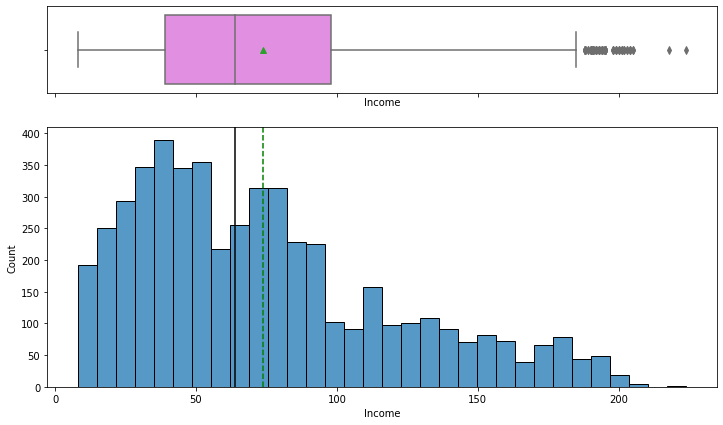

In [ ]:
histogram_boxplot(data=df, feature='Income')

We will treat outliers

In [ ]:
df = treat_outliers(df=df, col='Income')

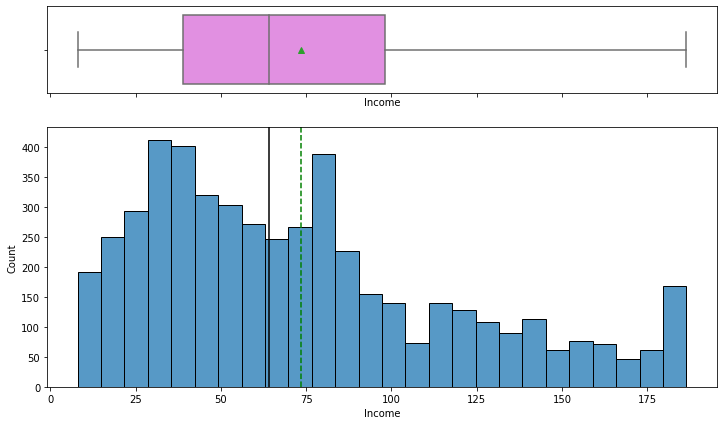

In [ ]:
histogram_boxplot(data=df, feature='Income')

In [ ]:
df.Income.describe()

count   5,000.00
mean       73.62
std        45.63
min         8.00
25%        39.00
50%        64.00
75%        98.00
max       186.50
Name: Income, dtype: float64

**Insights**
- Treated outliers
- Data is slightly right skewed


## CCAvg

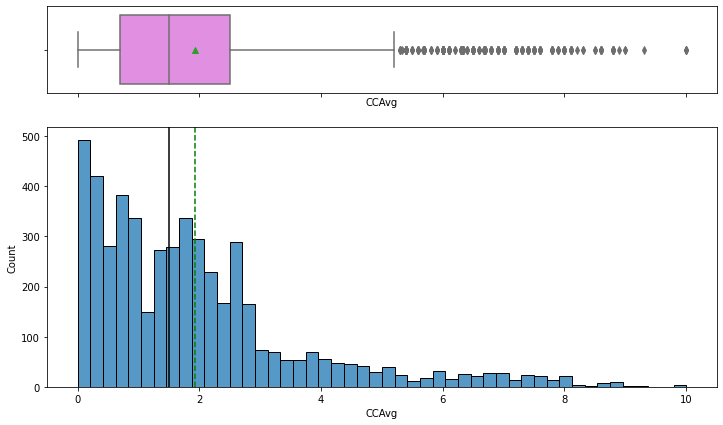

In [ ]:
histogram_boxplot(data=df, feature='CCAvg')

In [ ]:
df = treat_outliers(df=df, col='CCAvg')

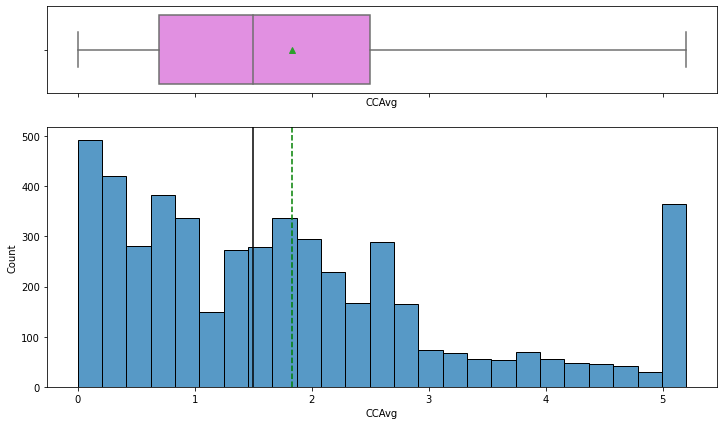

In [ ]:
histogram_boxplot(data=df, feature='CCAvg')

In [ ]:
df.CCAvg.describe()

count   5,000.00
mean        1.83
std         1.45
min         0.00
25%         0.70
50%         1.50
75%         2.50
max         5.20
Name: CCAvg, dtype: float64

** Insights**
- Treated outliers
- Data is right skewed (as expected)

## Mortgage

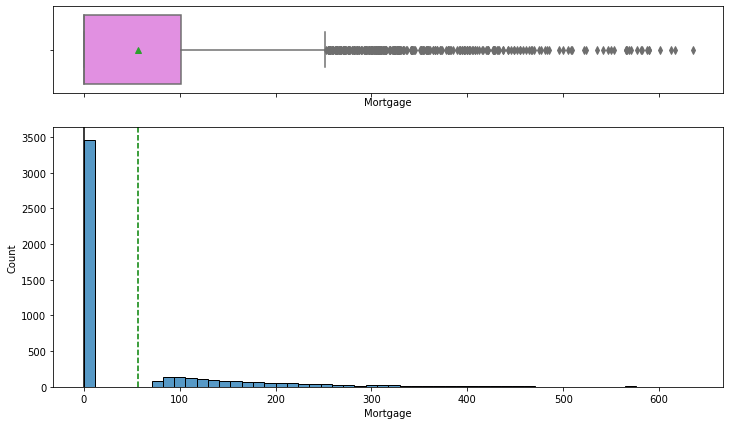

In [ ]:
histogram_boxplot(data=df, feature='Mortgage')

In [ ]:
df[df.Mortgage == 0].Mortgage.size

3462

**Insights**
- Almost 70% (3,462 out of 5000) records does not have a mortgage
- We will work with this column later on on data engineering

## Family

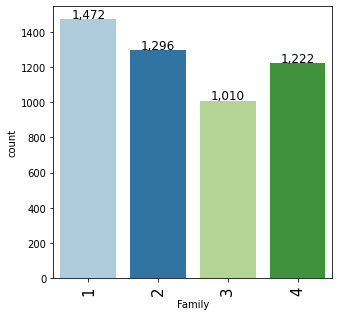

In [ ]:
labeled_barplot(data=df, feature='Family')

In [ ]:
df.Family = df.Family.astype(dtype='category')

**Insights** 
- Family ranges between 1 and 4
- Changed type to category


## Education

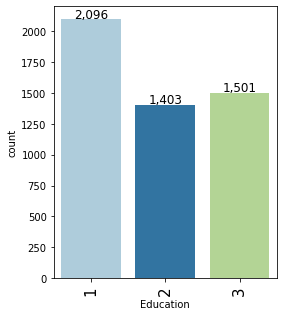

In [ ]:
labeled_barplot(data=df, feature='Education')

In [ ]:
df.Education = df.Education.astype(dtype='category')

** Insights **
- Education goes from 1 to 3
- Changed type to caategory

## Securities_Account

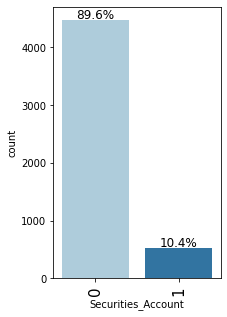

In [ ]:
labeled_barplot(data=df, feature='Securities_Account', perc=True)

In [ ]:
df.Securities_Account = df.Securities_Account.astype(dtype='category')

**Insights**
- Almost 90% does not have a securities account with the bank
- Changed type to category

## CD_Account

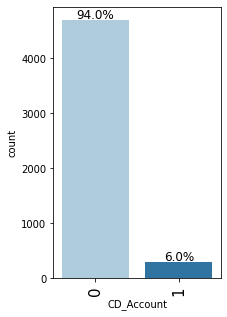

In [ ]:
labeled_barplot(data=df, feature='CD_Account', perc=True)

In [ ]:
df.CD_Account = df.CD_Account.astype(dtype='category')

** Insights **
- 94% does not have a certificate of deposit with the bank
- Changed type to category


## Online

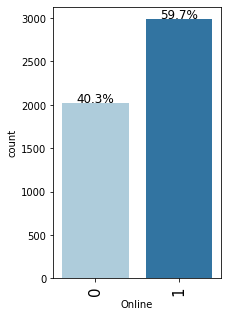

In [ ]:
labeled_barplot(data=df, feature='Online', perc=True)

In [ ]:
 df.Online = df.Online.astype(dtype='category')

** Insights **
- Almost 60% utilize the online platform of the bank
- Changed type to category

## CreditCard

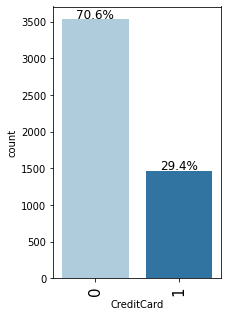

In [ ]:
labeled_barplot(data=df, feature='CreditCard', perc=True)

In [ ]:
df.CreditCard = df.CreditCard.astype(dtype='category')

** Insights **
- 70.6% of users have a credit card with another bank
- Changed type to category

# Feature Engineer

## County

We will use uszipcode to find the county of the zipcodes

In [ ]:
pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from uszipcode import SearchEngine

In [ ]:
zipEngine = SearchEngine()

In [ ]:
wrong_zips = []
def county_by_zip(val):
  zipcode = zipEngine.by_zipcode(val)
  if zipcode:
    return zipcode.county
  else:
    if val not in wrong_zips: #if val is not found on uszipcodes database add it to wrong_zips and return Nan
      wrong_zips.append(val)
    return np.nan
df['County'] = df.ZIPCode.apply(county_by_zip)

In [ ]:
wrong_zips

[92717, 93077, 92634, 96651]

Will group in Other all the counties that had less than 1% and the null values that came from wrong zips

In [ ]:
counties_other = pd.concat([df.County.value_counts(dropna=False, normalize=True),
           df.County.value_counts(dropna=False)],
          axis = 1,
          keys=('perc','count')).loc[lambda row : row.perc<=0.01].index.to_list()
counties_other

[nan,
 'Solano County',
 'San Luis Obispo County',
 'Humboldt County',
 'Sonoma County',
 'Fresno County',
 'Placer County',
 'Butte County',
 'Shasta County',
 'El Dorado County',
 'Stanislaus County',
 'San Benito County',
 'San Joaquin County',
 'Mendocino County',
 'Siskiyou County',
 'Tuolumne County',
 'Merced County',
 'Trinity County',
 'Lake County',
 'Imperial County',
 'Napa County']

In [ ]:
def counties_to_other(val):
  if val in counties_other:
    return 'Other'
  else:
    return val
df.County = df.County.apply(counties_to_other)

In [ ]:
pd.concat([df.County.value_counts(dropna=False, normalize=True),
           df.County.value_counts(dropna=False)],
          axis = 1,
          keys=('perc','count'))

,perc,count
Los Angeles County,0.22,1095
San Diego County,0.11,568
Santa Clara County,0.11,563
Alameda County,0.10,500
Other,0.07,346
Orange County,0.07,339
San Francisco County,0.05,257
San Mateo County,0.04,204
Sacramento County,0.04,184
Santa Barbara County,0.03,154


In [ ]:
df.County.nunique()

19

In [ ]:
df.County = df.County.astype(dtype='category')

In [ ]:
df.drop('ZIPCode', inplace=True, axis=1)

** Insights **
- Created County feature based on the zip codes
- All counties with less than 1% and nan values were grouped in Other category
- Dropped ZIPCode feature

## Has_mortgage

In [ ]:
df['Has_mortgage'] = df.Mortgage.apply(lambda x: x if x == 0 else 1)

In [ ]:
print(f'Has mortgage:\n{df.Has_mortgage.value_counts()}') , print(f'Mortgage == 0 count: {df[df.Mortgage == 0].Mortgage.size}')

Has mortgage:
0    3462
1    1538
Name: Has_mortgage, dtype: int64
Mortgage == 0 count: 3462


(None, None)

In [ ]:
df.Has_mortgage = df.Has_mortgage.astype(dtype='category')

In [ ]:
df.drop('Mortgage', axis=1, inplace=True)

** Insights **
- Has_mortgage feature has been created with values 0 and 1
- Checked that the count of zeros matches in mortgage and has_mortgage (3462)
- Dropped Mortgage feature

# Bivariate analysis

## Correlation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   float64 
 3   Family              5000 non-null   category
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Personal_Loan       5000 non-null   int64   
 7   Securities_Account  5000 non-null   category
 8   CD_Account          5000 non-null   category
 9   Online              5000 non-null   category
 10  CreditCard          5000 non-null   category
 11  County              5000 non-null   category
 12  Has_mortgage        5000 non-null   category
dtypes: category(8), float64(2), int64(3)
memory usage: 236.1 KB


In [ ]:
cat_cols = df.dtypes[df.dtypes == 'category'].index
num_cols = df.dtypes[(df.dtypes == 'float') | (df.dtypes == 'int64')].index

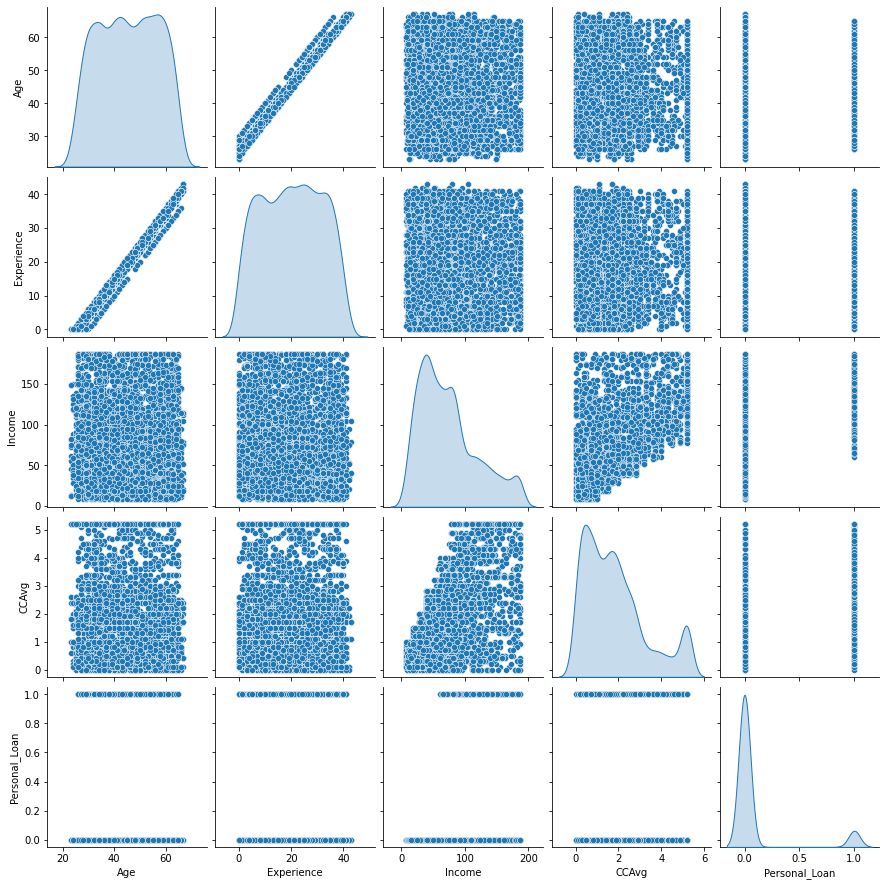

In [ ]:
sns.pairplot(data=df, diag_kind='kde')

** Insights **
- Personal loan does not seems to have a great correlation with any variable
- Age and Experience seem to be very correlated 

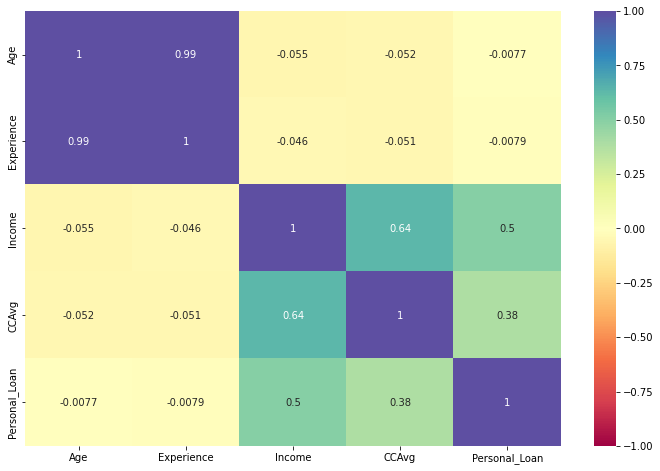

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)

In [ ]:
df.drop('Experience', axis=1, inplace=True)

** Insights **
- Age and Experience have a correlation of .99 so we will drop one of them
- CCAvg and Income are somehow correlated 
- We dropped Experience as it was 99% correlated to Age

## Target variable vs other features

### Target vs numerical features

In [ ]:
num_cols = df.dtypes[(df.dtypes == 'float') | (df.dtypes == 'int64')].index.to_list()
num_cols.remove('Personal_Loan')
num_cols

['Age', 'Income', 'CCAvg']

#### vs Age

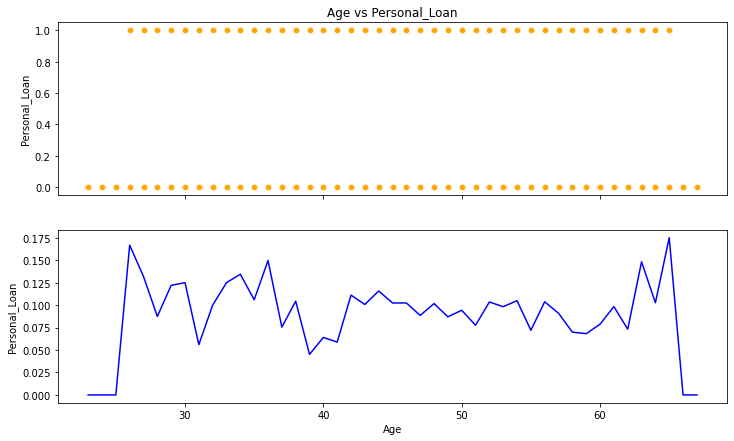

In [ ]:
scatter_lineplot(data=df, feature_y='Personal_Loan', feature_x='Age')

** Insights **
- There is no visible correlation between the two variables

#### vs Income

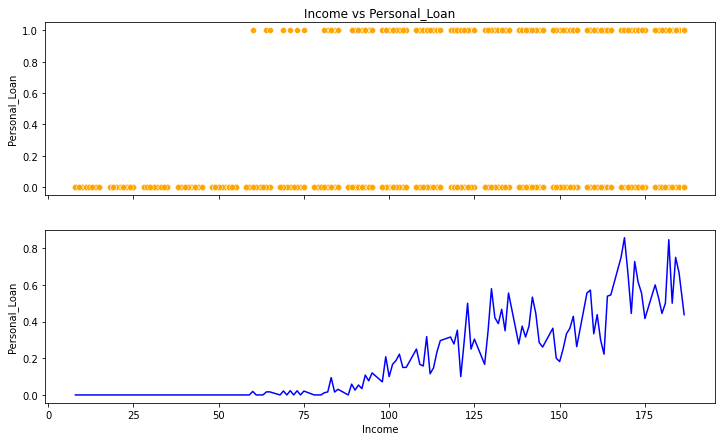

In [ ]:
scatter_lineplot(data=df, feature_y='Personal_Loan', feature_x='Income')

** Insights **
- No one with Income lower than 50k hass a Personal Loan



#### vs CCAvg

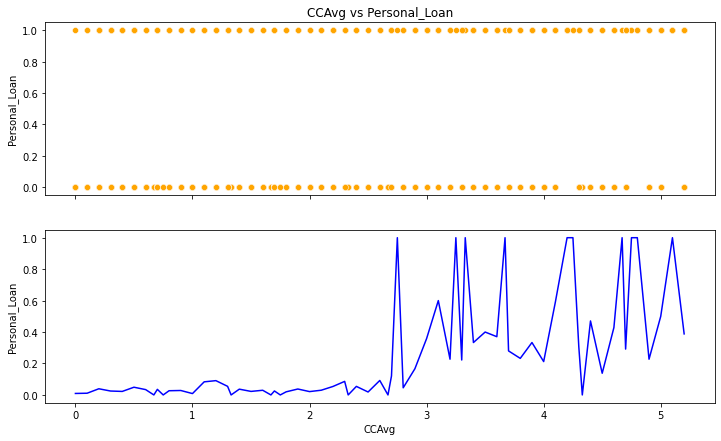

In [ ]:
scatter_lineplot(data=df, feature_y='Personal_Loan', feature_x='CCAvg')

** Insights **
- As the CCAvg grows seems that is more probable to have a personal loan

# Data Preprocesing

In [ ]:
#Initialize lists of preprocessing
cols_to_normalize = ['Age']
cols_to_log = ['Income','CCAvg']
cols_to_dummies = ['Family','Education','County']


## Normalize

In [ ]:
mean_age = df.Age.mean()
mean_age

45.3384

In [ ]:
std_age = df.Age.std()
std_age

11.463165630542667

In [ ]:
# NORMALIZE
scaler = StandardScaler()
for col in cols_to_normalize:
  df[[col]] = scaler.fit_transform(df[[col]])

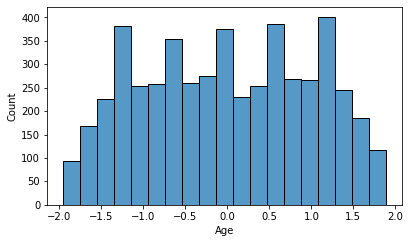

In [ ]:
f1 = plt.figure(figsize=(14,8))
position = 1 #initialize position variable 
for i, feature in enumerate(cols_to_normalize): #itarate for different hues
  plt.subplot(2, 2, position)
  position += 1
  sns.histplot(data=df, x=feature)

## LOG

In [ ]:
# LOG
for colname in cols_to_log:
  if df[colname].min() > 0:
    df[colname + '_log'] = np.log(df[colname]) #we didnt add a value since df.New_Price.min() > 0
  else:
    df[colname + '_log'] = np.log(df[colname] + 0.01) #we add a small value
df.drop(cols_to_log, axis=1, inplace=True)

## Create dummies

In [ ]:
df = pd.get_dummies(df, columns=cols_to_dummies)


In [ ]:
df.columns

Index(['Age', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online',
       'CreditCard', 'Has_mortgage', 'Income_log', 'CCAvg_log', 'Family_1',
       'Family_2', 'Family_3', 'Family_4', 'Education_1', 'Education_2',
       'Education_3', 'County_Alameda County', 'County_Contra Costa County',
       'County_Kern County', 'County_Los Angeles County',
       'County_Marin County', 'County_Monterey County', 'County_Orange County',
       'County_Other', 'County_Riverside County', 'County_Sacramento County',
       'County_San Bernardino County', 'County_San Diego County',
       'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Barbara County', 'County_Santa Clara County',
       'County_Santa Cruz County', 'County_Ventura County',
       'County_Yolo County'],
      dtype='object')

## Split data

In [ ]:
X = df.drop('Personal_Loan', axis=1)
y = df['Personal_Loan']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 3500
Number of rows in test data = 1500


# Logistic regresion model




## Model building



In [ ]:
#check how balanced is the data
y.value_counts(normalize=True).to_frame() 

,Personal_Loan
0,0.90
1,0.10


In [ ]:
y_train.value_counts(normalize=True).to_frame()

,Personal_Loan
0,0.91
1,0.09


In [ ]:
y_test.value_counts(normalize=True).to_frame()

,Personal_Loan
0,0.90
1,0.10


In [ ]:
lg = LogisticRegression(solver="newton-cg", random_state=1, class_weight={0: 0.9, 1: 0.1})
model = lg.fit(X_train, y_train)

## Model performance evaluation and improvement

- False positives are poteentially very costly for the company since we are predicting to give a loan to someone who should not have it.

- False negatives represe3nt an opportunity cost (which is not as big as FP) because we are not giving a loan to some one who should, so we have an oportunity cost

- We will be focusing on PRECISION score and after that in F1 score\

### Performance on training set


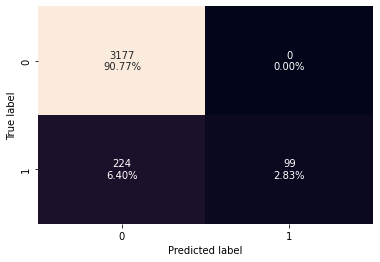

In [ ]:
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

In [ ]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.94,0.31,1.00,0.47


### Performance on test set

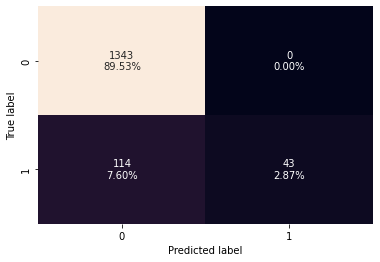

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)

In [ ]:
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.92,0.27,1.00,0.43


### ROC-AUC

#### ROC-AUC on training set

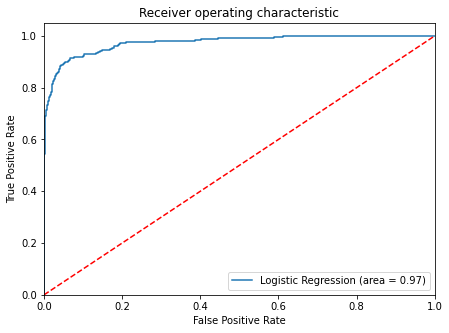

In [ ]:
# Find the roc auc score for training data
logit_roc_auc_train = roc_auc_score(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### ROC-AUC on test set

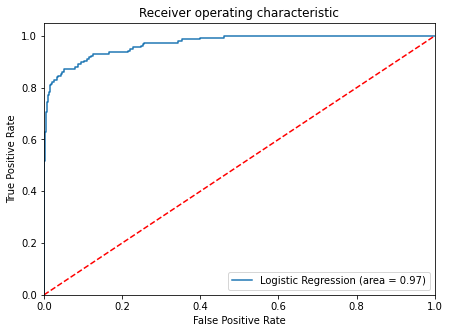

In [ ]:
# Find the roc auc score for training data
logit_roc_auc_test = roc_auc_score(
    y_test, lg.predict_proba(X_test)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### Model performance improvement

#### Optimal threshold using AUC-ROC curve

Optimal thresold is the value that best separated the True positive rate and False positive rate. 

In [ ]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
# roc_curve returns the fpr, tpr and threshold values which takes the original data and predicted probabilities for the class 1.
fpr, tpr, thresholds = roc_curve(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1

optimal_idx = np.argmax(
    tpr - fpr
)  # Finds the index that contains the max difference between tpr and fpr
optimal_threshold_auc_roc = thresholds[
    optimal_idx
]  # stores the optimal threshold value
print(optimal_threshold_auc_roc)

0.029055613645187845


#### Checking model performance on training set

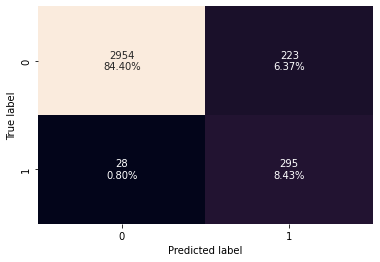

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.93,0.91,0.57,0.70


#### Checking model performance on test set

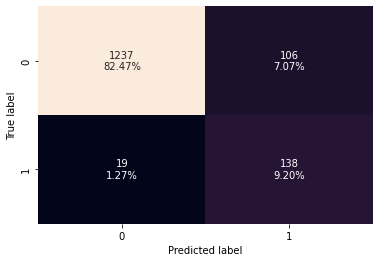

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

In [ ]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.92,0.88,0.57,0.69


#### Let's use Precision-Recall curve and see if we can find a better threshold

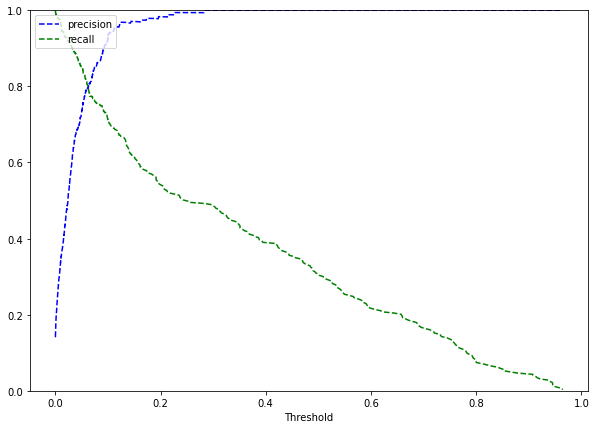

In [ ]:
# Find the predicted probabilities for class 1
y_scores = lg.predict_proba(X_train)[:, 1]
# Find fpr, tpr and threshold values
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
# Plot recall precision curve
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [ ]:
# setting the threshold
optimal_threshold_curve = 0.09

 #### Checking model performance on training set

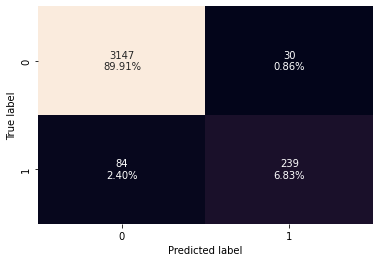

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

In [ ]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.97,0.74,0.89,0.81


#### Checking model performance on test set

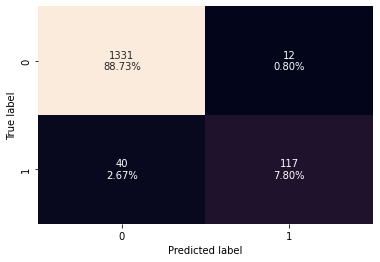

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

In [ ]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test set performance:")
log_reg_model_test_perf_threshold_curve

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.97,0.75,0.91,0.82


### Logistic Regresion Model Performance Summary

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.029 Threshold",
    "Logistic Regression-0.09 Threshold",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.029 Threshold,Logistic Regression-0.09 Threshold
Accuracy,0.94,0.93,0.97
Recall,0.31,0.91,0.74
Precision,1.00,0.57,0.89
F1,0.47,0.70,0.81


In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.029 Threshold",
    "Logistic Regression-0.09 Threshold",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.029 Threshold,Logistic Regression-0.09 Threshold
Accuracy,0.92,0.92,0.97
Recall,0.27,0.88,0.75
Precision,1.00,0.57,0.91
F1,0.43,0.69,0.82


## Logistic regression model conclusion

- The model performs better at 0.09 Threshold because it has:
  - 0.91 Precision 
  - 0.82 F1 score (higher of all models)

- 0.5 Threshold (default) results are misleading, it has a perfect precision of 1 but its recall and F1 score are very low

- 0.029 threshold hass a very low precision which is key in our project

- As a conclusion the model with 0.09 threshold is the best one


# Decision tree model


## Model building


In [ ]:
tree1 = DecisionTreeClassifier(
    criterion="gini", class_weight={0: 0.9, 1: 0.1}, random_state=23
)
tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.9, 1: 0.1}, random_state=23)

## Model performance evaluation and improvement

### Performance on training set

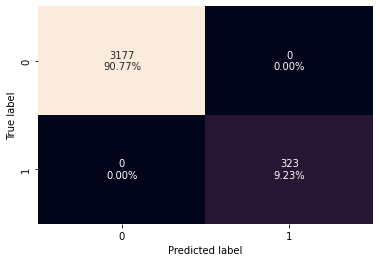

In [ ]:
confusion_matrix_sklearn(tree1, X_train, y_train)

In [ ]:
# checking model performance for this model
tree_model_train_perf = model_performance_classification_sklearn_with_threshold(
    tree1, X_train, y_train
)
print("Test set performance:")
tree_model_train_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


### Performance on test set

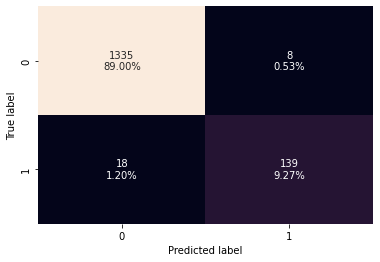

In [ ]:
confusion_matrix_sklearn(tree1, X_test, y_test)

In [ ]:
# checking model performance for this model
tree_model_test_perf = model_performance_classification_sklearn_with_threshold(
    tree1, X_test, y_test
)
print("Test set performance:")
tree_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.89,0.95,0.91


The whole tree is actually performing good in testing data

## Visualizing the tree

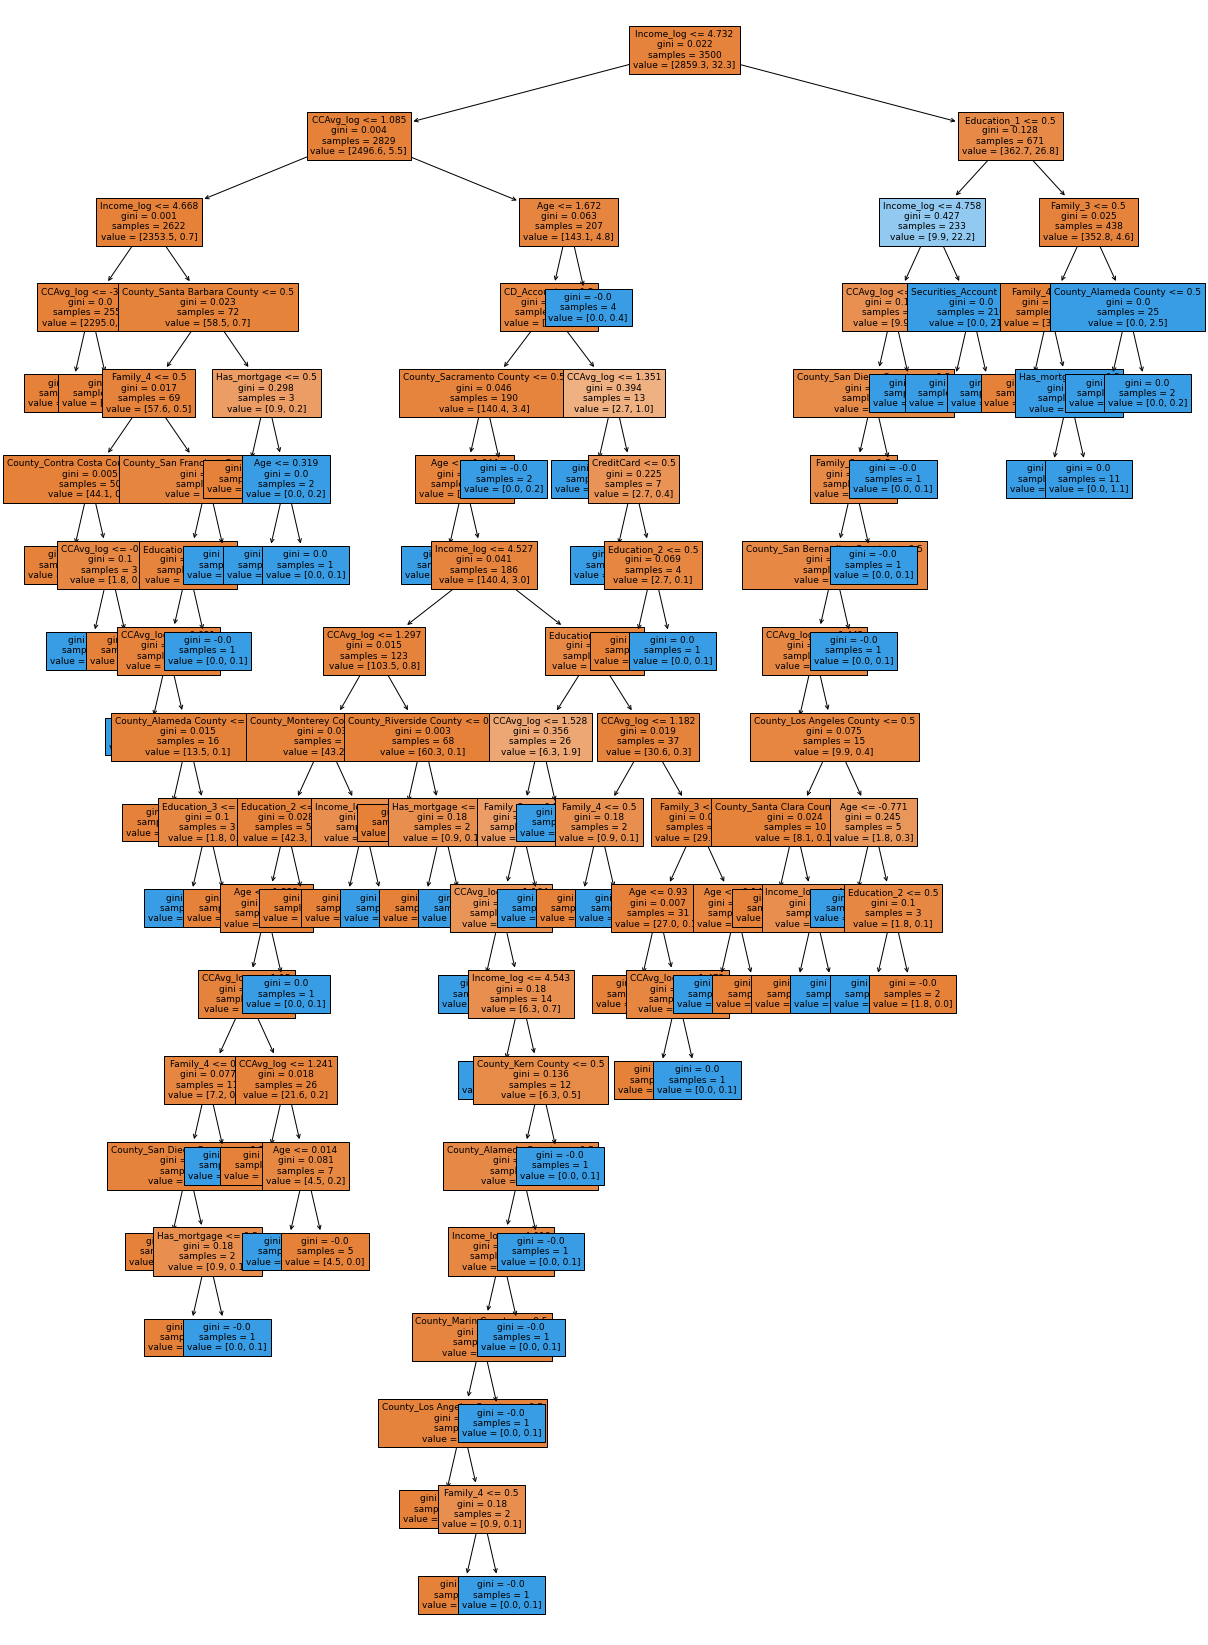

In [ ]:
feature_names = X_train.columns.to_list()
plt.figure(figsize=(20, 30))
out = tree.plot_tree(
    tree1,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
print(tree.export_text(tree1, feature_names=feature_names, show_weights=True))

|--- Income_log <= 4.73
|   |--- CCAvg_log <= 1.09
|   |   |--- Income_log <= 4.67
|   |   |   |--- CCAvg_log <= -3.41
|   |   |   |   |--- weights: [48.60, 0.00] class: 0
|   |   |   |--- CCAvg_log >  -3.41
|   |   |   |   |--- weights: [2246.40, 0.00] class: 0
|   |   |--- Income_log >  4.67
|   |   |   |--- County_Santa Barbara County <= 0.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- County_Contra Costa County <= 0.50
|   |   |   |   |   |   |--- weights: [42.30, 0.00] class: 0
|   |   |   |   |   |--- County_Contra Costa County >  0.50
|   |   |   |   |   |   |--- CCAvg_log <= -0.15
|   |   |   |   |   |   |   |--- weights: [0.00, 0.10] class: 1
|   |   |   |   |   |   |--- CCAvg_log >  -0.15
|   |   |   |   |   |   |   |--- weights: [1.80, 0.00] class: 0
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- County_San Francisco County <= 0.50
|   |   |   |   |   |   |--- Education_1 <= 0.50
|   |   |   |   |   |   |   |--- CCAvg_log <= 0.02
|   |   | 

The tree above is very complex and difficult to interpret.

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        tree1.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                              Imp
Education_1                  0.44
Income_log                   0.24
Family_3                     0.09
Family_4                     0.08
CCAvg_log                    0.06
Age                          0.03
Has_mortgage                 0.01
CreditCard                   0.01
CD_Account                   0.01
Education_2                  0.01
County_Sacramento County     0.01
County_Marin County          0.00
County_San Diego County      0.00
County_San Francisco County  0.00
Education_3                  0.00
County_Alameda County        0.00
County_San Bernardino County 0.00
County_Kern County           0.00
County_Los Angeles County    0.00
County_Santa Barbara County  0.00
County_Riverside County      0.00
County_Santa Clara County    0.00
County_Monterey County       0.00
County_Contra Costa County   0.00
Securities_Account           0.00
County_Orange County         0.00
County_Other                 0.00
Family_2                     0.00
Family_1      

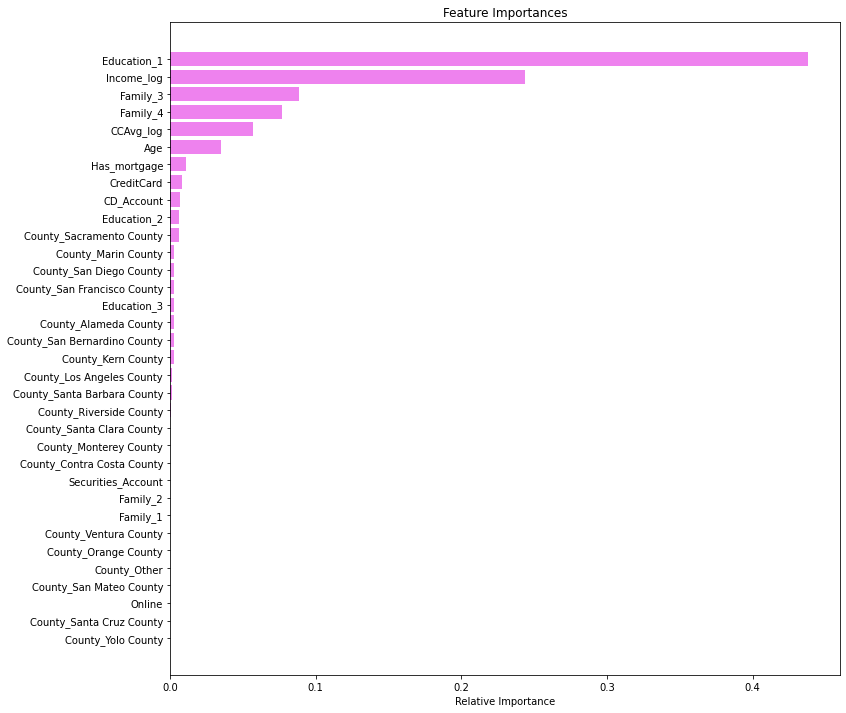

In [ ]:
importances = tree1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- According to this tree Education_1 is the most relevant feature to predict Personal_Loan

### Pre-Pruning: Using GridSearch for Hyperparameter tuning of our tree model

In [ ]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=23, class_weight={0: 0.9, 1: 0.1})

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
}

# Type of scoring used to compare parameter combinations
# we will use precision as is the most imortant metric in our case
scorer = make_scorer(precision_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.9, 1: 0.1}, criterion='entropy',
                       max_depth=5, random_state=23)

#### Checking performance on training set

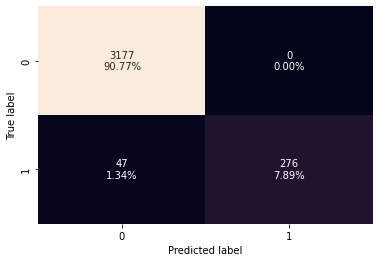

In [ ]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [ ]:
# checking model performance for this model
decision_tree_tune_perf_train = model_performance_classification_sklearn_with_threshold(
    estimator, X_train, y_train
)
print("Test set performance:")
decision_tree_tune_perf_train

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.85,1.00,0.92


#### Checking performance on test set

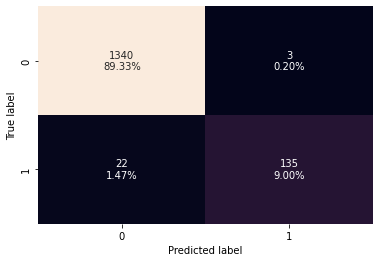

In [ ]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [ ]:
# checking model performance for this model
decision_tree_tune_perf_test = model_performance_classification_sklearn_with_threshold(
    estimator, X_test, y_test
)
print("Test set performance:")
decision_tree_tune_perf_test

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.86,0.98,0.92


Prunned tree is giving good results

#### Visualizing the Decision Tree

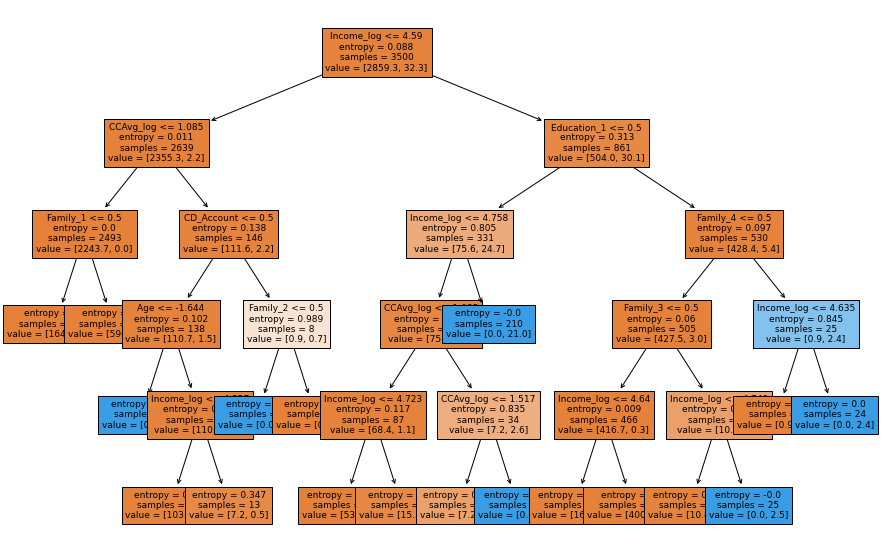

In [ ]:
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- Income_log <= 4.59
|   |--- CCAvg_log <= 1.09
|   |   |--- Family_1 <= 0.50
|   |   |   |--- weights: [1647.00, 0.00] class: 0
|   |   |--- Family_1 >  0.50
|   |   |   |--- weights: [596.70, 0.00] class: 0
|   |--- CCAvg_log >  1.09
|   |   |--- CD_Account <= 0.50
|   |   |   |--- Age <= -1.64
|   |   |   |   |--- weights: [0.00, 0.20] class: 1
|   |   |   |--- Age >  -1.64
|   |   |   |   |--- Income_log <= 4.53
|   |   |   |   |   |--- weights: [103.50, 0.80] class: 0
|   |   |   |   |--- Income_log >  4.53
|   |   |   |   |   |--- weights: [7.20, 0.50] class: 0
|   |   |--- CD_Account >  0.50
|   |   |   |--- Family_2 <= 0.50
|   |   |   |   |--- weights: [0.00, 0.70] class: 1
|   |   |   |--- Family_2 >  0.50
|   |   |   |   |--- weights: [0.90, 0.00] class: 0
|--- Income_log >  4.59
|   |--- Education_1 <= 0.50
|   |   |--- Income_log <= 4.76
|   |   |   |--- CCAvg_log <= 1.09
|   |   |   |   |--- Income_log <= 4.72
|   |   |   |   |   |--- weights: [53.10, 0.20] class: 0
| 

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        estimator.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

# Here we will see that importance of features has increased

                              Imp
Income_log                   0.60
Education_1                  0.19
CCAvg_log                    0.07
Family_4                     0.06
Family_3                     0.05
CD_Account                   0.01
Family_2                     0.01
Age                          0.01
Family_1                     0.00
County_Santa Clara County    0.00
County_Orange County         0.00
County_Santa Cruz County     0.00
County_Ventura County        0.00
County_Santa Barbara County  0.00
County_San Mateo County      0.00
County_San Francisco County  0.00
County_San Diego County      0.00
County_San Bernardino County 0.00
County_Sacramento County     0.00
County_Riverside County      0.00
County_Other                 0.00
County_Kern County           0.00
County_Monterey County       0.00
County_Marin County          0.00
County_Los Angeles County    0.00
Securities_Account           0.00
County_Contra Costa County   0.00
County_Alameda County        0.00
Education_3   

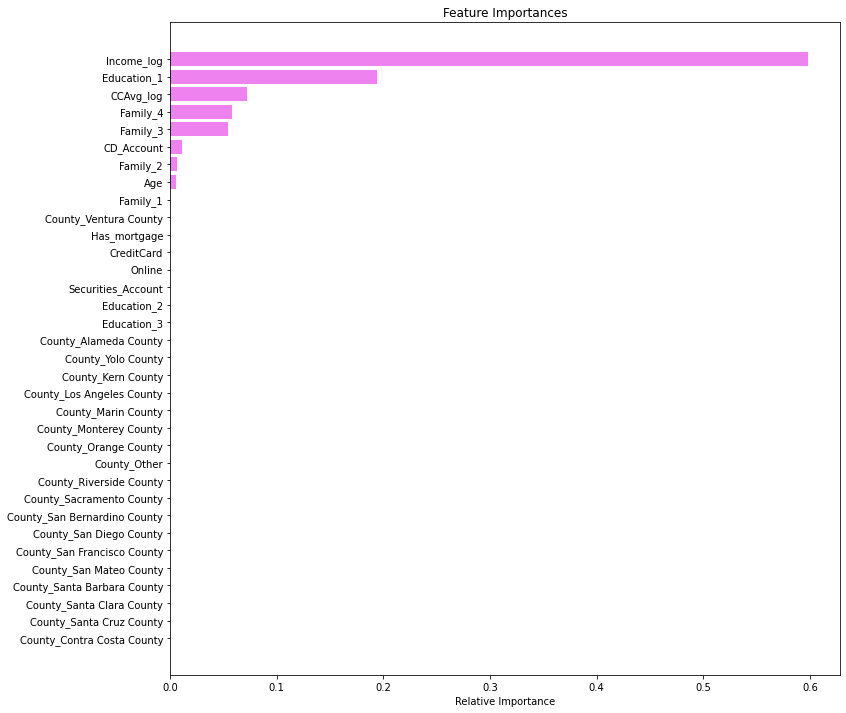

In [ ]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Cost Complexity Pruning

#### Total impurity of leaves vs effective alphas of pruned tree

In [ ]:
clf = DecisionTreeClassifier(random_state=23, class_weight={0: 0.9, 1: 0.1})
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
pd.options.display.float_format = '{:,.25f}'.format
pd.DataFrame(path)


,ccp_alphas,impurities
0,0.0000000000000000000000000,-0.0000000000000003575051753
1,0.0000000000000000000383948,-0.0000000000000003574667805
2,0.0000000000000000467648238,-0.0000000000000003107019568
3,0.0000000000000003300145236,0.0000000000000000193125668
4,0.0000000000000003934503543,0.0000000000000004127629211
5,0.0000000000000004405799283,0.0000000000000008533428494
6,0.0000340425715866631632927,0.0000680851431741796750104
7,0.0000341091911005313427126,0.0001363035253752423604356
8,0.0000341611868186720709045,0.0002046258990125864886921
9,0.0000342471732651792757848,0.0004101089386036621434010


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

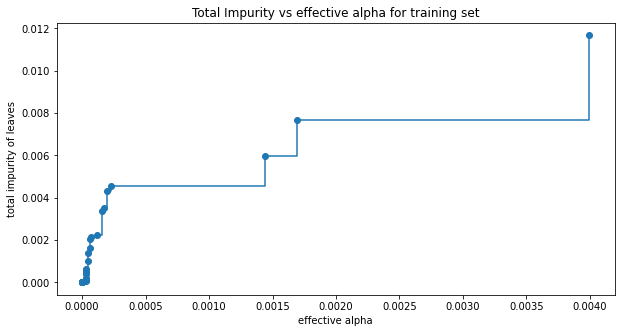

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=23, ccp_alpha=ccp_alpha, class_weight={0: 0.9, 1: 0.1}
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.005209491629436231


In [ ]:
metrics_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = precision_score(y_train, pred_train)
    metrics_train.append(values_train)

In [ ]:
metrics_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = precision_score(y_test, pred_test)
    metrics_test.append(values_test)

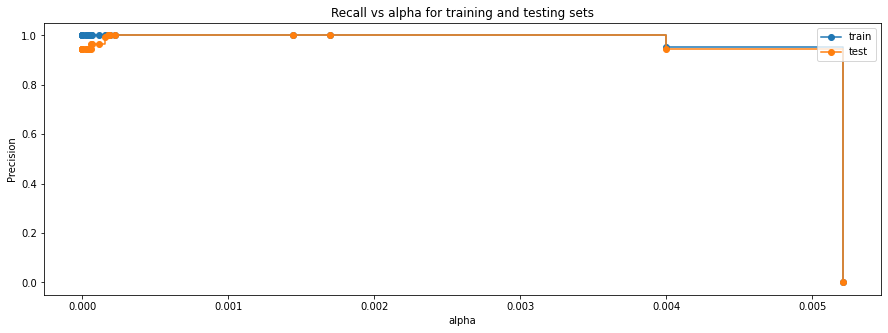

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Precision")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, metrics_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, metrics_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(metrics_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.00017426928022244384,
                       class_weight={0: 0.9, 1: 0.1}, random_state=23)


In [ ]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00017426928022244384,
                       class_weight={0: 0.9, 1: 0.1}, random_state=23)

#### Checking performance on training set

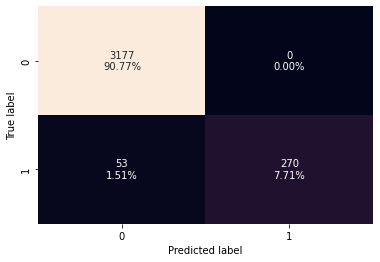

In [ ]:
confusion_matrix_sklearn(best_model, X_train, y_train)

In [ ]:
# checking model performance for this model
decision_tree_tune_best_ccpa_train = model_performance_classification_sklearn_with_threshold(
    best_model, X_train, y_train
)
print("Test set performance:")
decision_tree_tune_best_ccpa_train

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.84,1.00,0.91


#### Checking performance on testing set

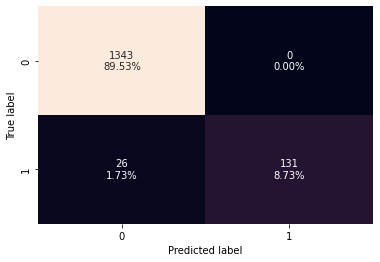

In [ ]:
confusion_matrix_sklearn(best_model, X_test, y_test)

In [ ]:
# checking model performance for this model
decision_tree_tune_best_ccpa_test = model_performance_classification_sklearn_with_threshold(
    best_model, X_test, y_test
)
print("Test set performance:")
decision_tree_tune_best_ccpa_test

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.83,1.00,0.91


#### Visualizing the tree

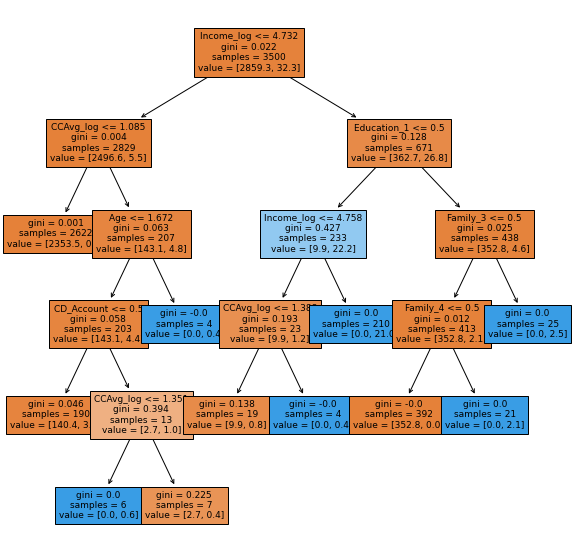

In [ ]:
plt.figure(figsize=(10, 10))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- Income_log <= 4.73
|   |--- CCAvg_log <= 1.09
|   |   |--- weights: [2353.50, 0.70] class: 0
|   |--- CCAvg_log >  1.09
|   |   |--- Age <= 1.67
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- weights: [140.40, 3.40] class: 0
|   |   |   |--- CD_Account >  0.50
|   |   |   |   |--- CCAvg_log <= 1.35
|   |   |   |   |   |--- weights: [0.00, 0.60] class: 1
|   |   |   |   |--- CCAvg_log >  1.35
|   |   |   |   |   |--- weights: [2.70, 0.40] class: 0
|   |   |--- Age >  1.67
|   |   |   |--- weights: [0.00, 0.40] class: 1
|--- Income_log >  4.73
|   |--- Education_1 <= 0.50
|   |   |--- Income_log <= 4.76
|   |   |   |--- CCAvg_log <= 1.39
|   |   |   |   |--- weights: [9.90, 0.80] class: 0
|   |   |   |--- CCAvg_log >  1.39
|   |   |   |   |--- weights: [0.00, 0.40] class: 1
|   |   |--- Income_log >  4.76
|   |   |   |--- weights: [0.00, 21.00] class: 1
|   |--- Education_1 >  0.50
|   |   |--- Family_3 <= 0.50
|   |   |   |--- Family_4 <= 0.50
|   |   |   |   |--- weights

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                              Imp
Education_1                  0.51
Income_log                   0.27
Family_3                     0.09
Family_4                     0.08
CCAvg_log                    0.03
Age                          0.01
CD_Account                   0.01
County_Santa Clara County    0.00
County_Santa Cruz County     0.00
County_Santa Barbara County  0.00
County_San Mateo County      0.00
County_Monterey County       0.00
County_Ventura County        0.00
County_San Francisco County  0.00
County_San Diego County      0.00
County_San Bernardino County 0.00
County_Sacramento County     0.00
County_Riverside County      0.00
County_Other                 0.00
County_Orange County         0.00
County_Kern County           0.00
County_Marin County          0.00
County_Los Angeles County    0.00
Securities_Account           0.00
County_Contra Costa County   0.00
County_Alameda County        0.00
Education_3                  0.00
Education_2                  0.00
Family_2      

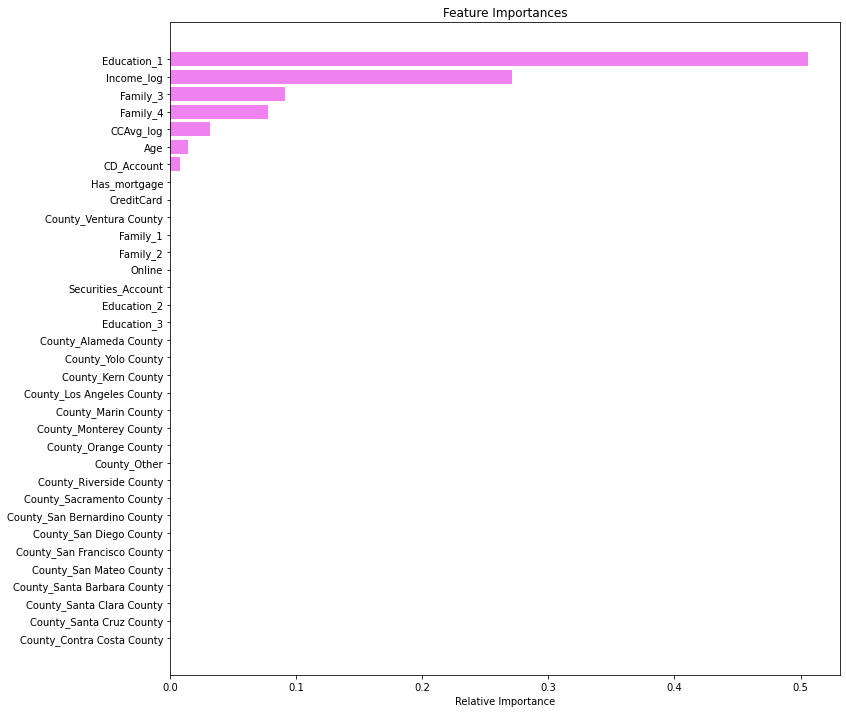

In [ ]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Decision Tree Model Performance Summary

In [ ]:
# training performance comparison

tree_models_train_comp_df = pd.concat(
    [
        tree_model_train_perf.T,
        decision_tree_tune_perf_train.T,
        decision_tree_tune_best_ccpa_train.T,
    ],
    axis=1,
)
tree_models_train_comp_df.columns = [
    "Perfect Tree",
    "Pre-Pruned Tree",
    "Post-Pruned Tree",
]
print("Training performance comparison:")
tree_models_train_comp_df

Training performance comparison:


,Perfect Tree,Pre-Pruned Tree,Post-Pruned Tree
Accuracy,1.00,0.99,0.98
Recall,1.00,0.85,0.84
Precision,1.00,1.00,1.00
F1,1.00,0.92,0.91


In [ ]:
# testing performance comparison

tree_models_test_comp_df = pd.concat(
    [
        tree_model_test_perf.T,
        decision_tree_tune_perf_test.T,
        decision_tree_tune_best_ccpa_test.T,
    ],
    axis=1,
)
tree_models_test_comp_df.columns = [
    "Perfect Tree",
    "Pre-Pruned Tree",
    "Post-Pruned Tree",
]
print("Training performance comparison:")
tree_models_test_comp_df

Training performance comparison:


,Perfect Tree,Pre-Pruned Tree,Post-Pruned Tree
Accuracy,0.98,0.98,0.98
Recall,0.89,0.86,0.83
Precision,0.95,0.98,1.00
F1,0.91,0.92,0.91


## Decision tree model conclusion

- Both pre-pruned and post-pruned trees are very good
- We will keep the Post-Pruned as the best one because it has the best Precision score on test data 

# Best Model

In [ ]:
# testing performance comparison

best_models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf_threshold_curve.T,
        decision_tree_tune_best_ccpa_test.T,
    ],
    axis=1,
)
best_models_test_comp_df.columns = [
    "Best Logistic Regression",
    "Best Tree",
]
print("Test set performance comparison:")
best_models_test_comp_df

Test set performance comparison:


,Best Logistic Regression,Best Tree
Accuracy,0.97,0.98
Recall,0.75,0.83
Precision,0.91,1.00
F1,0.82,0.91


## Logistic Regresion vs Decision Tree

- It is perfectly clear that the decision tree model is performing way better than the logistic regression model
- Decision tree model has bested Logistic regression in every metric we mesured 

## Relevant Tree Rules

In [ ]:
print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- Income_log <= 4.73
|   |--- CCAvg_log <= 1.09
|   |   |--- weights: [2353.50, 0.70] class: 0
|   |--- CCAvg_log >  1.09
|   |   |--- Age <= 1.67
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- weights: [140.40, 3.40] class: 0
|   |   |   |--- CD_Account >  0.50
|   |   |   |   |--- CCAvg_log <= 1.35
|   |   |   |   |   |--- weights: [0.00, 0.60] class: 1
|   |   |   |   |--- CCAvg_log >  1.35
|   |   |   |   |   |--- weights: [2.70, 0.40] class: 0
|   |   |--- Age >  1.67
|   |   |   |--- weights: [0.00, 0.40] class: 1
|--- Income_log >  4.73
|   |--- Education_1 <= 0.50
|   |   |--- Income_log <= 4.76
|   |   |   |--- CCAvg_log <= 1.39
|   |   |   |   |--- weights: [9.90, 0.80] class: 0
|   |   |   |--- CCAvg_log >  1.39
|   |   |   |   |--- weights: [0.00, 0.40] class: 1
|   |   |--- Income_log >  4.76
|   |   |   |--- weights: [0.00, 21.00] class: 1
|   |--- Education_1 >  0.50
|   |   |--- Family_3 <= 0.50
|   |   |   |--- Family_4 <= 0.50
|   |   |   |   |--- weights

In [ ]:
#print rules with if, else notation
tree_to_code(best_model, feature_names)

def predict(, Securities_Ac, CD_Ac, O, Credi, Has_mor, Incom, CCAv, Fam, Fam, Fam, Fam, Educat, Educat, Educat, County_Alameda_C, County_Contra_Costa_C, County_Kern_C, County_Los_Angeles_C, County_Marin_C, County_Monterey_C, County_Orange_C, County_, County_Riverside_C, County_Sacramento_C, County_San_Bernardino_C, County_San_Diego_C, County_San_Francisco_C, County_San_Mateo_C, County_Santa_Barbara_C, County_Santa_Clara_C, County_Santa_Cruz_C, County_Ventura_C, County_Yolo_C):
    if Income_log <= 4.731793:
        if CCAvg_log <= 1.085047:
            return [[2.3535e+03 7.0000e-01]] class 0
        else:  # if CCAvg_log > 1.085047
            if Age <= 1.671747:
                if CD_Account <= 0.5:
                    return [[140.4   3.4]] class 0
                else:  # if CD_Account > 0.5
                    if CCAvg_log <= 1.350583:
                        return [[0.  0.6]] class 1
                    else:  # if CCAvg_log > 1.350583
                        return [[2.7 0.4]] 

### Feature value interpretations

In [ ]:
print(f'Income_log: 4.731793 equals Income of {np.ceil(np.exp(4.731793))}')
print(f'CCAvg_log: 1.085047 equals CCAvg of {round(np.exp(1.085047),1)}')
print(f'Age of 1.671747 equals an actual age of {np.floor((1.671747 * std_age) + mean_age)}')
print(f'CD_Account <= 0.5 equals CD_Account of 0')
print(f'CCAvg_log: 1.350583 equals CCAvg of {np.floor(np.exp(1.350583)*10)/10}')
print(f'Education_1 <= 0.5 equals Education_1 = 0 which means education = 2 or 3')
print(f'Income_log: 4.757808 equals Income of {np.floor(np.exp(4.757808))}')
print(f'CCAvg_log: 1.387546 equals CCAvg of {np.floor(np.exp(1.387546)*10)/10}')
print(f'Family_3 <= 0.5 equals Family_3 = 0 which means Family = 1 or 2 or 4')
print(f'Family_4 <= 0.5 equals Family_4 = 0 which means Family = 1 or 2 or 3')


Income_log: 4.731793 equals Income of 114.0
CCAvg_log: 1.085047 equals CCAvg of 3.0
Age of 1.671747 equals an actual age of 64.0
CD_Account <= 0.5 equals CD_Account of 0
CCAvg_log: 1.350583 equals CCAvg of 3.8
Education_1 <= 0.5 equals Education_1 = 0 which means education = 2 or 3
Income_log: 4.757808 equals Income of 116.0
CCAvg_log: 1.387546 equals CCAvg of 4.0
Family_3 <= 0.5 equals Family_3 = 0 which means Family = 1 or 2 or 4
Family_4 <= 0.5 equals Family_4 = 0 which means Family = 1 or 2 or 3


# Actionable Insights & Recommendations


Our recommendations to the marketing team are the following:
- Make a marketing campaign focusing on the following features:
  - Education_1
  - Income
  - Family_3
  - Family_4
  - CCAvg_log
  - Age
  - CD_Account

- Following these profiles
  - Profile 1:
    - Income <= 114 
    - CCAvg in (3, 3.8] 
    - Age <= 64
    - CD_Account = 1
  - Profile 2:
    - Income <= 114
    - CCavg > 3
    - Age > 64
  - Profile 3:
    - Income between (114, 116]
    - Education = 2 or 3
    - CCAvg > 4
  - Profile 4:
    - Income > 116
    - Education = 2 or 3
  - Profile 5:
    - Income > 114
    - Education = 1
    - Family = 4
  - Profile 6:
    - Income > 114
    - Education = 1
    - Family = 3
    


# Convert ipynb to HTML



In [ ]:
%%shell
jupyter nbconvert --to html ///content/Personal_loan_campaign_EMS.ipynb

[NbConvertApp] Converting notebook ///content/Personal_loan_campaign_EMS.ipynb to html
[NbConvertApp] Writing 2547105 bytes to ///content/Personal_loan_campaign_EMS.html
